# Long Short-Term Memory (LSTM)

# Explanation

### What is LSTM? 
LSTM stands for long short-term memory networks, used in the field of Deep Learning. It is a variety of recurrent neural networks (RNNs) that are capable of learning long-term dependencies, especially in sequence prediction problems. 
LSTM has feedback connections, i.e., it is capable of processing the entire sequence of data, apart from single data points such as images.
This finds application in speech recognition, machine translation, etc. LSTM is a special kind of RNN, which shows outstanding performance on a large variety of problems.

## imports to LSTM algoruthim

In [32]:

import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scalecast.Forecaster import Forecaster


## Getting the data


In [53]:
# Now, we will load the data set and look at some initial rows and data types of the columns:
data = pd.read_csv('data/AirPassengers.csv')
print (data.head())
print ('\n Data Types:')
print (data.dtypes)

# The data contains a particular month and number of passengers travelling in that month. In order to read the data as a time series, we have to pass special arguments to the read_csv command:
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y')
data = pd.read_csv('data/AirPassengers.csv', parse_dates=['Month'], index_col='Month',date_parser=dateparse)
print ('\n Parsed Data:')
print (data.head())

        Month  Value
0  01/01/1949    112
1  01/03/1949    132
2  01/05/1949    121
3  01/07/1949    148
4  01/09/1949    136

 Data Types:
Month    object
Value     int64
dtype: object

 Parsed Data:
            Value
Month            
1949-01-01    112
1949-03-01    132
1949-05-01    121
1949-07-01    148
1949-09-01    136


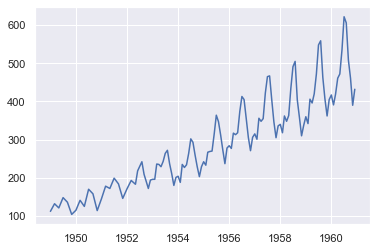

In [65]:
ts = data['Value'] 
plt.plot(ts)

In [76]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    #Determing rolling statistics
  
    rolmean = pd.rolling_mean(timeseries,12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [77]:
test_stationarity(ts)

AttributeError: module 'pandas' has no attribute 'rolling_mean'